In [1]:
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from matplotlib import pyplot

from scipy.io import loadmat
import os
from os import path

import warnings

DATA_DIR = 'data/preprocessed'

np.random.seed(3)

In [2]:
# Using plotly + cufflinks in offline mode
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import cufflinks
cufflinks.go_offline(connected=True)

In [3]:
import re

Data = {}
for file in os.listdir(DATA_DIR):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        data = loadmat(path.join(DATA_DIR, filename))
        index = re.findall(r'\d+', filename)[-1]
        Data['electrode_'+str(index)] = np.squeeze(data['p1st'])

df = pd.DataFrame(Data)

In [4]:
df = df.T
print("The dataset contains {0} rows and {1} columns".format(df.shape[0], df.shape[1]))
df.head()

The dataset contains 103 rows and 1802762 columns


,0,1,2,3,4,5,6,7,8,9,...,1802752,1802753,1802754,1802755,1802756,1802757,1802758,1802759,1802760,1802761
electrode_1,41.716805,38.812707,35.041442,30.383131,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.788420,...,-19.207158,-19.262882,-18.675911,-17.487823,-15.763623,-13.582821,-11.026026,-8.168095,-5.070118,-1.778862
electrode_10,8.082549,11.133247,14.296853,17.412122,20.338028,22.955956,25.170391,26.907064,28.111660,28.743052,...,33.226267,23.681644,14.175155,5.087411,-3.229318,-10.462901,-16.353534,-20.704262,-23.390363,-24.367822
electrode_100,31.998051,33.929033,36.232118,38.845610,41.689640,44.676844,47.714919,50.709624,53.570229,56.209865,...,-60.975075,-58.528180,-54.766563,-49.793458,-43.776389,-36.936385,-29.537547,-21.874607,-14.252103,-6.968529
electrode_101,-37.003890,-39.624473,-41.209704,-41.773115,-41.354811,-40.018294,-37.845699,-34.934051,-31.393004,-27.339603,...,-0.425525,-1.024245,-1.689228,-2.386713,-3.115931,-3.916899,-4.872857,-6.102297,-7.746489,-9.956018
electrode_102,22.816080,20.600437,18.836262,17.521505,16.602531,15.978348,15.508288,15.026483,14.350623,13.297051,...,26.047437,26.329604,25.668915,24.330952,22.598718,20.752124,19.046779,17.703170,16.894929,16.738447


In [5]:
def plot_random_series(df, n_series, start_index, end_index):
    sample = df.sample(n_series, random_state=8)
    sample.T.iloc[start_index:end_index,:].iplot()
    
plot_random_series(df, 6, 0, 2000)

In [6]:
single_elec_df = df.loc[['electrode_1'],:]
print(single_elec_df.shape)
single_elec_df.head()

(1, 1802762)


,0,1,2,3,4,5,6,7,8,9,...,1802752,1802753,1802754,1802755,1802756,1802757,1802758,1802759,1802760,1802761
electrode_1,41.716805,38.812707,35.041442,30.383131,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.78842,...,-19.207158,-19.262882,-18.675911,-17.487823,-15.763623,-13.582821,-11.026026,-8.168095,-5.070118,-1.778862


In [8]:
single_elec_df.to_csv(r'.\data\preprocessed\csv\elec_1.csv')

In [8]:
# configure parameters
n_lag = 2**9 # window_width
n_seq = 2**5 # estimation_seq
first_n_samples = 20000 # samples to use

In [9]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat all
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return supervised, train, test

In [11]:
# load dataset
series = single_elec_df.T[:first_n_samples]
n_test = min(math.floor(0.2*len(series)), 10000)
# prepare data
supervised, train, test = prepare_data(series, n_test, n_lag, n_seq)
print('Train: %s, Test: %s' % (train.shape, test.shape))

Train: (15457, 544), Test: (4000, 544)


In [12]:
print(supervised.shape)
supervised.head()

(19457, 544)


,var1(t-512),var1(t-511),var1(t-510),var1(t-509),var1(t-508),var1(t-507),var1(t-506),var1(t-505),var1(t-504),var1(t-503),...,var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29),var1(t+30),var1(t+31)
512,41.716805,38.812707,35.041442,30.383131,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.788420,...,-29.607517,-36.382068,-41.882933,-45.991190,-48.674418,-49.980838,-50.030888,-49.004865,-47.120562,-44.621989
513,38.812707,35.041442,30.383131,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.788420,-27.456232,...,-36.382068,-41.882933,-45.991190,-48.674418,-49.980838,-50.030888,-49.004865,-47.120562,-44.621989,-41.755972
514,35.041442,30.383131,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.788420,-27.456232,-38.565406,...,-41.882933,-45.991190,-48.674418,-49.980838,-50.030888,-49.004865,-47.120562,-44.621989,-41.755972,-38.753155
515,30.383131,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.788420,-27.456232,-38.565406,-49.873232,...,-45.991190,-48.674418,-49.980838,-50.030888,-49.004865,-47.120562,-44.621989,-41.755972,-38.753155,-35.817117
516,24.813376,18.310412,10.863951,2.491293,-6.757452,-16.788420,-27.456232,-38.565406,-49.873232,-61.096788,...,-48.674418,-49.980838,-50.030888,-49.004865,-47.120562,-44.621989,-41.755972,-38.753155,-35.817117,-33.117388


In [13]:
supervised.describe()

,var1(t-512),var1(t-511),var1(t-510),var1(t-509),var1(t-508),var1(t-507),var1(t-506),var1(t-505),var1(t-504),var1(t-503),...,var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29),var1(t+30),var1(t+31)
count,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,...,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000,19457.000000
mean,30.658111,30.654656,30.651189,30.647772,30.644476,30.641374,30.638544,30.636068,30.634025,30.632490,...,30.795925,30.794963,30.794045,30.793141,30.792223,30.791268,30.790263,30.789203,30.788092,30.786945
std,89.378458,89.379330,89.380322,89.381424,89.382617,89.383867,89.385128,89.386344,89.387441,89.388340,...,89.228921,89.229673,89.230456,89.231281,89.232164,89.233113,89.234133,89.235216,89.236344,89.237489
min,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,...,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673,-192.603673
25%,-21.344583,-21.350949,-21.362473,-21.367157,-21.371605,-21.381902,-21.383816,-21.422373,-21.445452,-21.464477,...,-21.227290,-21.227290,-21.227290,-21.227290,-21.227290,-21.227290,-21.227290,-21.227290,-21.227290,-21.227290
50%,23.924794,23.918822,23.894100,23.884364,23.877517,23.845666,23.845666,23.845666,23.845666,23.845666,...,23.595034,23.595034,23.595034,23.595034,23.595034,23.595034,23.595034,23.595034,23.595034,23.595034
75%,68.801904,68.801904,68.801904,68.801904,68.801904,68.801904,68.801904,68.801904,68.801904,68.801904,...,68.734316,68.734316,68.734316,68.734316,68.734316,68.734316,68.734316,68.734316,68.734316,68.734316
max,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,...,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224,700.153224


## Persistence Forecast

In [14]:
# make a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

In [15]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = persistence(X[-1], n_seq)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [16]:
forecasts = make_forecasts(train, test, n_lag, n_seq)

In [17]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:,(n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [18]:
evaluate_forecasts(test, forecasts, n_lag, n_seq)

t+1 RMSE: 5.365925
t+2 RMSE: 10.703395
t+3 RMSE: 15.985896
t+4 RMSE: 21.187712
t+5 RMSE: 26.284291
t+6 RMSE: 31.252576
t+7 RMSE: 36.071309
t+8 RMSE: 40.721278
t+9 RMSE: 45.185527
t+10 RMSE: 49.449506
t+11 RMSE: 53.501163
t+12 RMSE: 57.330989
t+13 RMSE: 60.932006
t+14 RMSE: 64.299702
t+15 RMSE: 67.431923
t+16 RMSE: 70.328728
t+17 RMSE: 72.992200
t+18 RMSE: 75.426244
t+19 RMSE: 77.636354
t+20 RMSE: 79.629381
t+21 RMSE: 81.413292
t+22 RMSE: 82.996938
t+23 RMSE: 84.389837
t+24 RMSE: 85.601980
t+25 RMSE: 86.643665
t+26 RMSE: 87.525354
t+27 RMSE: 88.257574
t+28 RMSE: 88.850834
t+29 RMSE: 89.315586
t+30 RMSE: 89.662189
t+31 RMSE: 89.900893
t+32 RMSE: 90.041834


In [19]:
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [20]:
# plot forecasts
# plot_forecasts(series, forecasts, n_test)

## WaveNet Model Forecast

In [21]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaled_values = scaler.fit_transform(raw_values)
#     scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # no rescale
    scaled_values = raw_values
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, supervised, train, test

In [22]:
# load dataset
series = single_elec_df.T[:first_n_samples]
n_test = min(math.floor(0.2*len(series)), 10000)
# prepare data
scaler, supervised, train, test = prepare_data(series, n_test, n_lag, n_seq)
print('Train: %s, Test: %s' % (train.shape, test.shape))

Train: (15457, 544), Test: (4000, 544)


In [23]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(9)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':n_seq})(x)

model = Model(history_seq, pred_seq_train)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2080

In [25]:
epochs = 10
batch_size = 2**5

# reshape training into [samples, timesteps, features]
trainX, trainy = train[:,:n_lag], train[:, n_lag:]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
trainy = trainy.reshape(trainy.shape[0], trainy.shape[1], 1)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_trainX_history = trainy[:,:-1,:1]
trainX = np.concatenate([trainX, lagged_trainX_history], axis=1)
print('train X: ' + str(trainX.shape))

train X: (15457, 543, 1)


In [26]:
print('train X: ' + str(trainX.shape))
print('train y: ' + str(trainy.shape))

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(trainX, 
                    trainy,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

train X: (15457, 543, 1)
train y: (15457, 32, 1)
Instructions for updating:
Use tf.cast instead.
Train on 12365 samples, validate on 3092 samples
Epoch 1/10
12365/12365 [==============================] - 134s 11ms/step - loss: 9.7752 - val_loss: 0.9219
Epoch 2/10
12365/12365 [==============================] - 125s 10ms/step - loss: 4.1003 - val_loss: 3.7642
Epoch 3/10
12365/12365 [==============================] - 128s 10ms/step - loss: 3.7133 - val_loss: 1.3595
Epoch 4/10
12365/12365 [==============================] - 125s 10ms/step - loss: 3.7647 - val_loss: 0.9097
Epoch 5/10
12365/12365 [==============================] - 126s 10ms/step - loss: 3.6903 - val_loss: 2.4356
Epoch 6/10
12365/12365 [==============================] - 128s 10ms/step - loss: 3.6412 - val_loss: 0.4827
Epoch 7/10
12365/12365 [==============================] - 126s 10ms/step - loss: 3.7788 - val_loss: 2.2799
Epoch 8/10
12365/12365 [==============================] - 129s 10ms/step - loss: 3.7175 - val_loss: 0.652

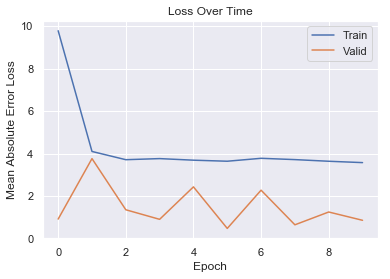

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [28]:
# reshape test into [samples, timesteps, features]
testX, testy = test[:,:n_lag], test[:, n_lag:]
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)
testy = testy.reshape(testy.shape[0], testy.shape[1], 1)
print(type(testX))
print('test X: ' + str(testX.shape))
print(type(testy))
print('test y: ' + str(testy.shape))

# Estimate model on test data
accuracy = model.evaluate(testX, testy, batch_size=batch_size)
print('Accuracy: %.2f MAE' % (accuracy))
# print('Accuracy: %.2f MSE (%.2f RMSE)' % (accuracy, math.sqrt(accuracy)))

<class 'numpy.ndarray'>
test X: (4000, 512, 1)
<class 'numpy.ndarray'>
test y: (4000, 32, 1)
4000/4000 [==============================] - 14s 4ms/step
Accuracy: 72.08 MAE


In [29]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,n_seq,1)) # initialize output (pred_steps time steps)  
    
    for i in range(n_seq):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [30]:
def predict_and_plot(X, y, sample_ind, tail_len=50, pred_len=20):
    
    pred_steps = min(y.shape[1], pred_len)
    
    x_series = X[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(x_series)
    
    x_series = x_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    y_series = y[sample_ind,:,:1].reshape(-1,1) 
        
    series_tail = np.concatenate([x_series[-tail_len:],y_series[:1]])
    series_tail_len = series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,series_tail_len+1),series_tail)
    plt.plot(range(series_tail_len,series_tail_len+pred_steps),y_series[:pred_steps,:],color='orange')
    plt.plot(range(series_tail_len,series_tail_len+pred_steps),pred_series[:pred_steps,:],color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

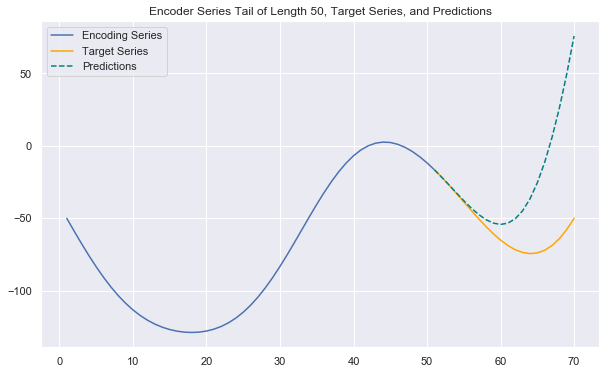

In [31]:
predict_and_plot(X=testX, y=testy, sample_ind=300)

In [32]:
# evaluate the WaveNet model
def make_predictions(data, n_lag):
    forecasts = list()
    for i in range(len(data)):
        X = data[i,:n_lag]
        X = X.reshape(1,X.shape[0],1)
        # make forecast
        forecast = predict_sequence(X)
        forecast = forecast.flatten()
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [33]:
# make predictions
forecasts = make_predictions(test, n_lag)

In [34]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_forecast = scaler.inverse_transform(forecast)
        inv_forecast = list(inv_forecast[0, :])
        # store
        inverted.append(inv_forecast)
    return inverted

In [35]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [36]:
actual = [row[n_lag:] for row in test]
# actual = inverse_transform(series, actual, scaler, n_test)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 0.977424
t+2 RMSE: 2.863360
t+3 RMSE: 5.846702
t+4 RMSE: 10.373268
t+5 RMSE: 17.037135
t+6 RMSE: 25.807724
t+7 RMSE: 37.006538
t+8 RMSE: 50.986335
t+9 RMSE: 68.037198
t+10 RMSE: 87.978305
t+11 RMSE: 110.856435
t+12 RMSE: 136.506433
t+13 RMSE: 164.521547
t+14 RMSE: 194.430624
t+15 RMSE: 225.753426
t+16 RMSE: 257.803769
t+17 RMSE: 289.896990
t+18 RMSE: 321.380231
t+19 RMSE: 351.562606
t+20 RMSE: 379.791846
t+21 RMSE: 405.590633
t+22 RMSE: 428.689106
t+23 RMSE: 448.904701
t+24 RMSE: 466.310716
t+25 RMSE: 481.222155
t+26 RMSE: 494.173014
t+27 RMSE: 505.857535
t+28 RMSE: 517.166236
t+29 RMSE: 529.070103
t+30 RMSE: 542.512694
t+31 RMSE: 558.324076
t+32 RMSE: 577.137243
